# Forest Fires (Anna)
- https://archive.ics.uci.edu/ml/datasets/Forest+Fires
- medium samples (513), small dimension (13)
- attribute characteristics: numeric, categorical
- Predict: area
- Missing values: No

## Preprocessing
- Convert 'month', 'day' to numeric variables 
- log transformation (log(1+area)) was applied to response variable 'area' since highly right skewed


### Linear Regression
- scaled data
- results:
    - <1 s
    - RMSE: 1.43211
    
### SVR
- scaled data
- results
    - few seconds
    - {'C': 0.8, 'epsilon': 0.5, 'kernel': 'rbf'}
    - RMSE: 1.41865
    
### Gradient Boosted Decision Tree
- scaled data
- results:
    - approx. 1 minute
    - {'max_depth': 4, 'min_samples_split': 3, 'n_estimators': 100}
    - RMSE: 1.38348
    
### AutoML
- with preprocessing
- with all samples:
    - 

In [59]:
import pandas as pd
import numpy as np
import sklearn as sk
import time
from sklearn import metrics
from sklearn.metrics import make_scorer
from sklearn import model_selection
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from datetime import datetime
from time import strptime
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from hpsklearn import HyperoptEstimator, svr_linear, gradient_boosting_regression, pca, normalizer, standard_scaler
from hyperopt import hp
from hyperopt import anneal, rand, tpe, mix
import math
from sklearn.decomposition import PCA

#%run './base.ipynb'

# Import Data
Data contains no missing values. Features 'month', 'day' are dtype object.

In [2]:
## import data 
data = pd.read_csv('/Users/annanau/Documents/Workspace/ML_Ex2/data/forest_fires/forestfires.csv')
#display(data.isna().sum()) 
#data.info()
print(data.head(10))

   X  Y month  day  FFMC    DMC     DC   ISI  temp  RH  wind  rain  area
0  7  5   mar  fri  86.2   26.2   94.3   5.1   8.2  51   6.7   0.0   0.0
1  7  4   oct  tue  90.6   35.4  669.1   6.7  18.0  33   0.9   0.0   0.0
2  7  4   oct  sat  90.6   43.7  686.9   6.7  14.6  33   1.3   0.0   0.0
3  8  6   mar  fri  91.7   33.3   77.5   9.0   8.3  97   4.0   0.2   0.0
4  8  6   mar  sun  89.3   51.3  102.2   9.6  11.4  99   1.8   0.0   0.0
5  8  6   aug  sun  92.3   85.3  488.0  14.7  22.2  29   5.4   0.0   0.0
6  8  6   aug  mon  92.3   88.9  495.6   8.5  24.1  27   3.1   0.0   0.0
7  8  6   aug  mon  91.5  145.4  608.2  10.7   8.0  86   2.2   0.0   0.0
8  8  6   sep  tue  91.0  129.5  692.6   7.0  13.1  63   5.4   0.0   0.0
9  7  5   sep  sat  92.5   88.0  698.6   7.1  22.8  40   4.0   0.0   0.0


# Visualizing/Exploring/Preprocessing
- data contains no missing values
- 'month', 'day' are dtype object, need to be made numeric
- log transformation was applied to response variable 'area' since highly right skewed (R^2 was increased by ~%4)

In [3]:
## Convert 'month', 'day' to numeric variables 
data2 = data
data2['month'] = pd.to_datetime(data['month'], format = '%b').dt.month
data2['day'] = data['day'].apply(lambda x: time.strptime(x, '%a')).apply(lambda x: x.tm_wday)

#data2.info()
#data2.describe()

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,log(1+area)
count,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000
mean,4.669246,4.299807,7.475822,3.259188,90.644681,110.872340,547.940039,9.021663,18.889168,44.288201,4.017602,0.021663,1.111026
std,2.313778,1.229900,2.275990,2.072929,5.520111,64.046482,248.066192,4.559477,5.806625,16.317469,1.791653,0.295959,1.398436
min,1.000000,2.000000,1.000000,0.000000,18.700000,1.100000,7.900000,0.000000,2.200000,15.000000,0.400000,0.000000,0.000000
25%,3.000000,4.000000,7.000000,1.000000,90.200000,68.600000,437.700000,6.500000,15.500000,33.000000,2.700000,0.000000,0.000000
50%,4.000000,4.000000,8.000000,4.000000,91.600000,108.300000,664.200000,8.400000,19.300000,42.000000,4.000000,0.000000,0.418710
75%,7.000000,5.000000,9.000000,5.000000,92.900000,142.400000,713.900000,10.800000,22.800000,53.000000,4.900000,0.000000,2.024193
max,9.000000,9.000000,12.000000,6.000000,96.200000,291.300000,860.600000,56.100000,33.300000,100.000000,9.400000,6.400000,6.995620


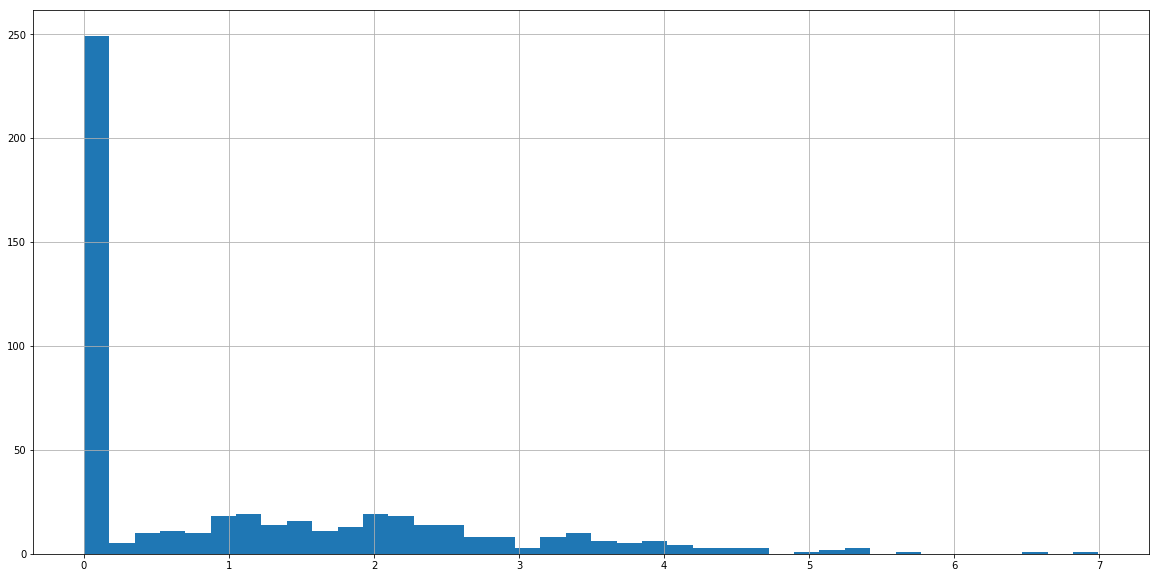

In [4]:
## Explore repsonse variable 'area'
#data2['area'].hist(bins = 40, figsize=(20,10))
#1 - (data2[data2['area'] == 0.0].shape[0]/data2.shape[0]) # for about 52% there is an obs. of a forest fire, 48% 'area' = 0.0

# Distribution of repsonse variable is highly right-skewed so we could apply log transformation
data2['area'] = data2['area'].apply(lambda x: np.log(x+1)) # np.log performs natural log
data2['area'].hist(bins = 40, figsize=(20,10))
data2.rename(index = str, columns = {"area": "log(1+area)"}, inplace = True)
data2.describe()

In [54]:
## all obs. where 'area' != 0.0
data3 = data2[data2['log(1+area)'] != 0.0]
display(data3.head(30))
data3.shape

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,log(1+area)
138,9,9,7,1,85.8,48.3,313.4,3.9,18.0,42,2.7,0.0,0.307485
139,1,4,9,1,91.0,129.5,692.6,7.0,21.7,38,2.2,0.0,0.357674
140,2,5,9,0,90.9,126.5,686.5,7.0,21.9,39,1.8,0.0,0.385262
141,1,2,8,2,95.5,99.9,513.3,13.2,23.3,31,4.5,0.0,0.438255
142,8,6,8,4,90.1,108.0,529.8,12.5,21.2,51,8.9,0.0,0.476234
143,1,2,7,5,90.0,51.3,296.3,8.7,16.6,53,5.4,0.0,0.536493
144,2,5,8,2,95.5,99.9,513.3,13.2,23.8,32,5.4,0.0,0.570980
145,6,5,8,3,95.2,131.7,578.8,10.4,27.4,22,4.0,0.0,0.641854
146,5,4,3,0,90.1,39.7,86.6,6.2,13.2,40,5.4,0.0,0.667829
147,8,3,9,1,84.4,73.4,671.9,3.2,24.2,28,3.6,0.0,0.672944


0.30748499999999995

In [26]:
## Checking for outliers 
# Descriptive statistics table
display(data.describe())

# Histograms
#data.hist(bins = 30, figsize=(30,20))

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,log(1+area)
count,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000
mean,4.669246,4.299807,7.475822,3.259188,90.644681,110.872340,547.940039,9.021663,18.889168,44.288201,4.017602,0.021663,1.111026
std,2.313778,1.229900,2.275990,2.072929,5.520111,64.046482,248.066192,4.559477,5.806625,16.317469,1.791653,0.295959,1.398436
min,1.000000,2.000000,1.000000,0.000000,18.700000,1.100000,7.900000,0.000000,2.200000,15.000000,0.400000,0.000000,0.000000
25%,3.000000,4.000000,7.000000,1.000000,90.200000,68.600000,437.700000,6.500000,15.500000,33.000000,2.700000,0.000000,0.000000
50%,4.000000,4.000000,8.000000,4.000000,91.600000,108.300000,664.200000,8.400000,19.300000,42.000000,4.000000,0.000000,0.418710
75%,7.000000,5.000000,9.000000,5.000000,92.900000,142.400000,713.900000,10.800000,22.800000,53.000000,4.900000,0.000000,2.024193
max,9.000000,9.000000,12.000000,6.000000,96.200000,291.300000,860.600000,56.100000,33.300000,100.000000,9.400000,6.400000,6.995620


/Users/annanau/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2961: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  exec(code_obj, self.user_global_ns, self.user_ns)


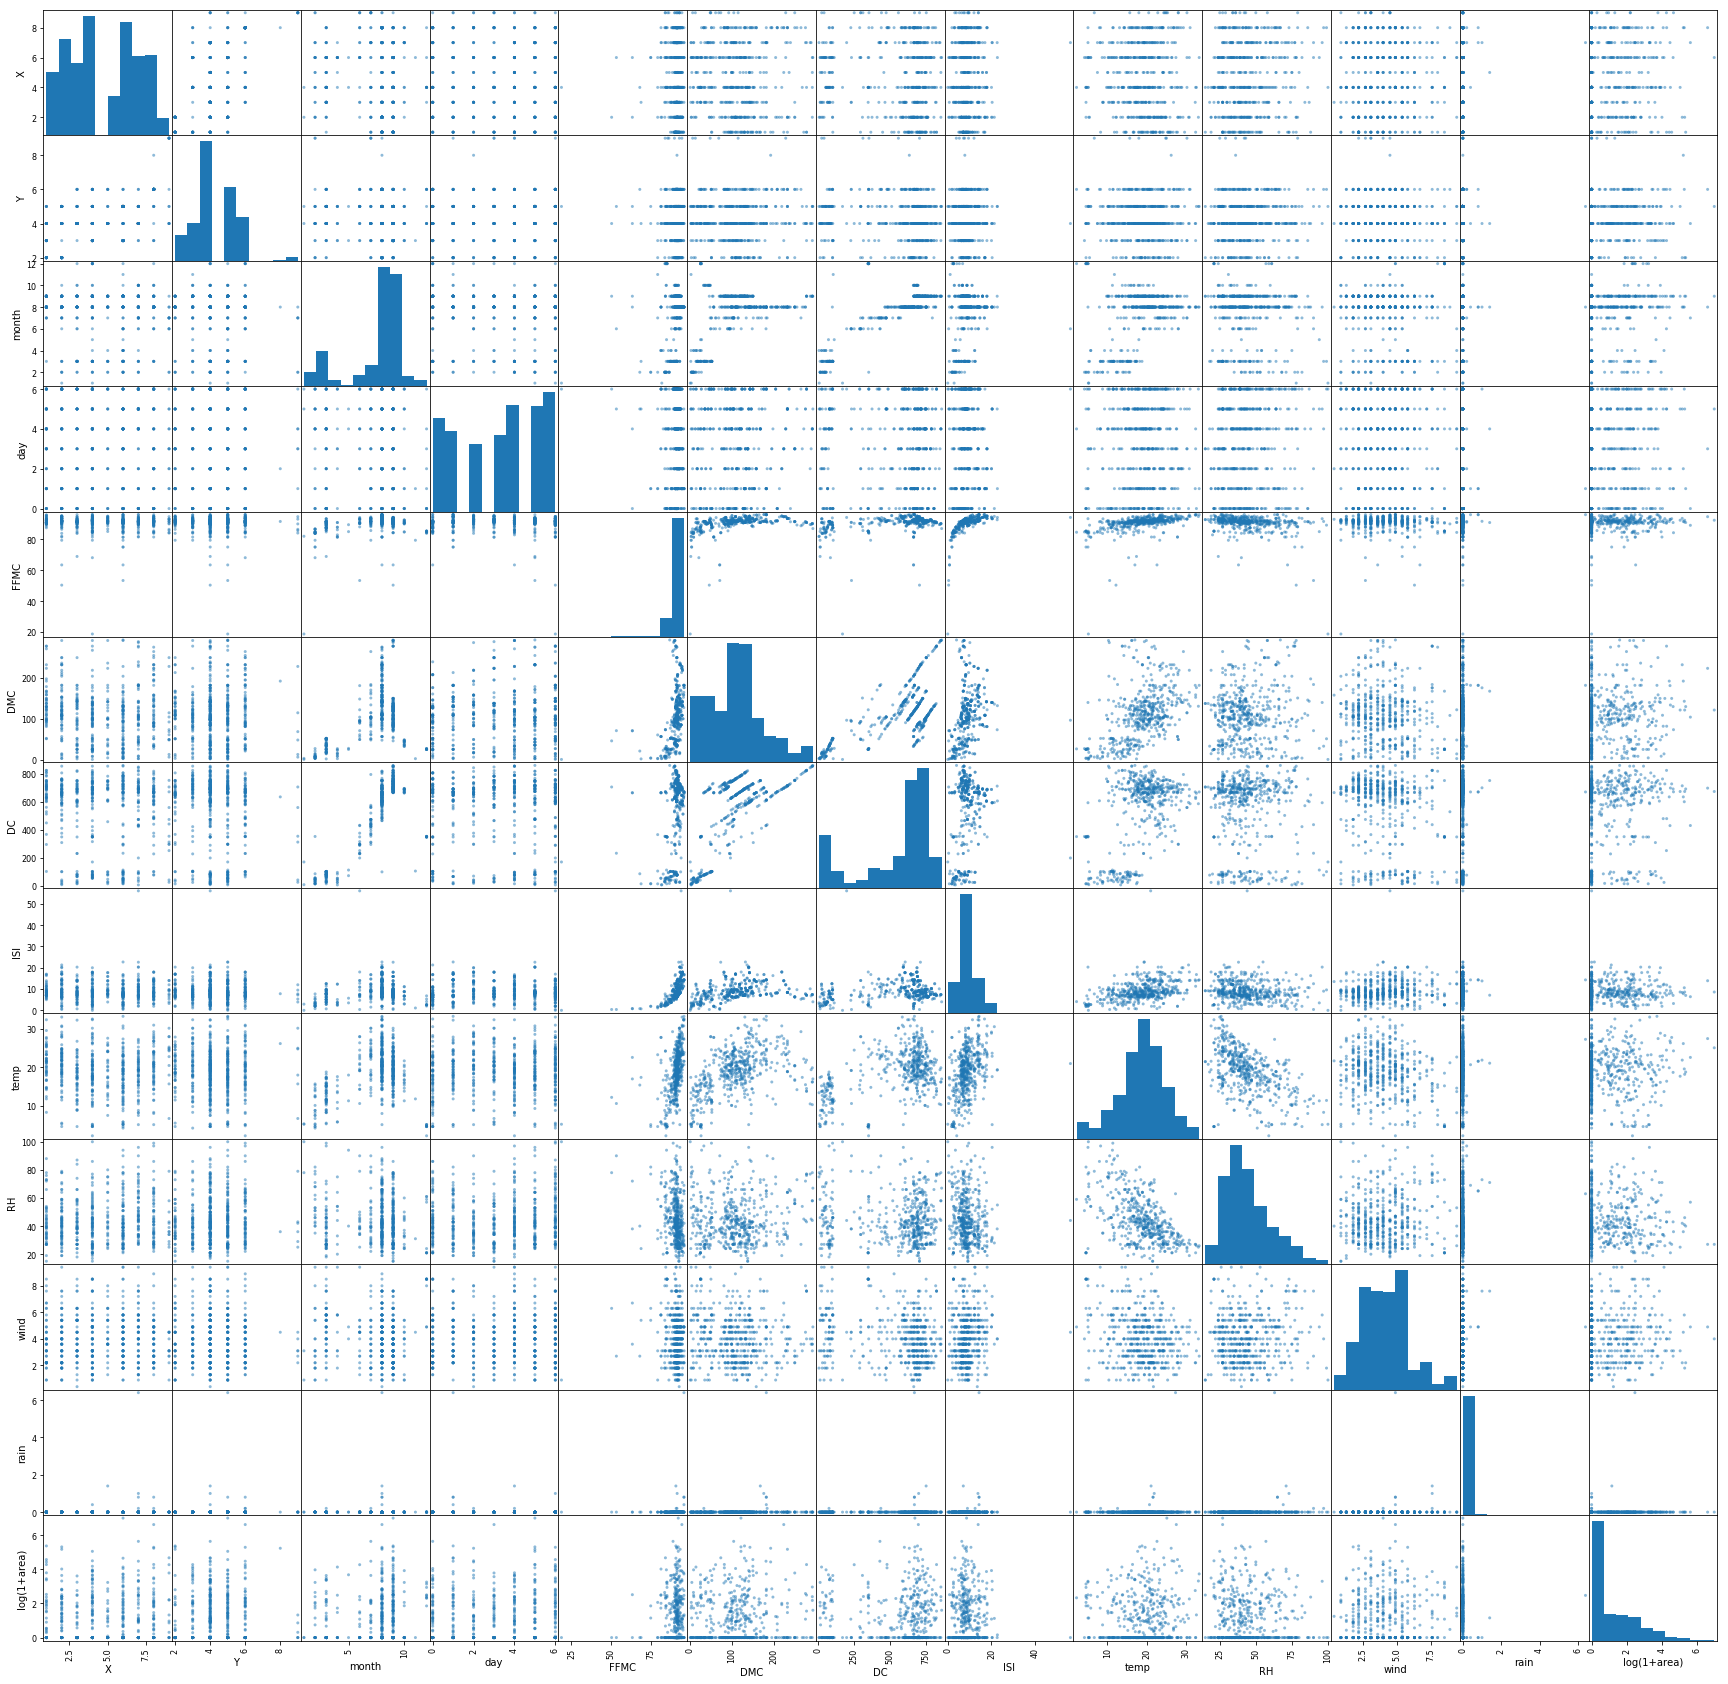

In [5]:
## Scatter Plot Matrix
fig = plt.figure(figsize=(30,30))
ax = fig.subplots()
sm = pd.plotting.scatter_matrix(data2, ax = ax)

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,log(1+area)
X,1.000000,0.539548,-0.065003,-0.024922,-0.021039,-0.048384,-0.085916,0.006210,-0.051258,0.085223,0.018798,0.065387,0.061995
Y,0.539548,1.000000,-0.066292,-0.005453,-0.046308,0.007782,-0.101178,-0.024488,-0.024103,0.062221,-0.020341,0.033234,0.038838
month,-0.065003,-0.066292,1.000000,-0.050837,0.291477,0.466645,0.868698,0.186597,0.368842,-0.095280,-0.086368,0.013438,0.114280
day,-0.024922,-0.005453,-0.050837,1.000000,-0.041068,0.062870,0.000105,0.032909,0.052190,0.092151,0.032478,-0.048340,0.000208
FFMC,-0.021039,-0.046308,0.291477,-0.041068,1.000000,0.382619,0.330512,0.531805,0.431532,-0.300995,-0.028485,0.056702,0.046799
DMC,-0.048384,0.007782,0.466645,0.062870,0.382619,1.000000,0.682192,0.305128,0.469594,0.073795,-0.105342,0.074790,0.067153
DC,-0.085916,-0.101178,0.868698,0.000105,0.330512,0.682192,1.000000,0.229154,0.496208,-0.039192,-0.203466,0.035861,0.066360
ISI,0.006210,-0.024488,0.186597,0.032909,0.531805,0.305128,0.229154,1.000000,0.394287,-0.132517,0.106826,0.067668,-0.010347
temp,-0.051258,-0.024103,0.368842,0.052190,0.431532,0.469594,0.496208,0.394287,1.000000,-0.527390,-0.227116,0.069491,0.053487
RH,0.085223,0.062221,-0.095280,0.092151,-0.300995,0.073795,-0.039192,-0.132517,-0.527390,1.000000,0.069410,0.099751,-0.053662


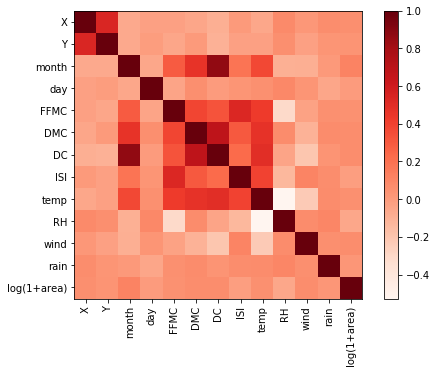

In [69]:
## Correlation 
display(data2.corr())

fig = plt.figure()
ax = fig.add_axes([1,1,1,1])
plt.imshow(data2.corr(), cmap = plt.cm.Reds, interpolation = 'nearest')
plt.colorbar()
ticks = [i for i in range(len(data2.columns))]
plt.xticks(ticks, data2.columns, rotation = 'vertical')
plt.yticks(ticks, data2.columns)
plt.show()

# Prediction Model

In [64]:
## Split into train (size = 2/3) and test data using sklearn's train/test splitter function
# data2 into train/test
X_train, X_test, y_train, y_test = train_test_split(data2.iloc[:, 0:12], 
                                                    data2.iloc[:, 12], test_size = 0.33, random_state= 123)
# data3 into train/test
X_train2, X_test2, y_train2, y_test2 = train_test_split(data3.iloc[:, 0:12], 
                                                        data3.iloc[:, 12], test_size = 0.33, random_state= 123)
# PCA
def my_pca(X_train, X_test, n_comp):
    pca = PCA(n_components = n_comp)
    pca.fit(X_train)
    pca_train = pd.DataFrame(pca.transform(X_train))
    pca_test = pd.DataFrame(pca.transform(X_test))
    return (pca_train, pca_test)

X_trainpca, X_testpca = my_pca(X_train, X_test, 12)


# Scalers
scaler = preprocessing.StandardScaler().fit(X_train) # for data2

scaler2 = preprocessing.StandardScaler().fit(X_train2) # for data3

#print(X_train.shape)
#print(y_train.shape)
#print(X_test.shape)
#print(y_test.shape)

In [84]:
### Regression Models

# Linear Regression
def linear_reg(X_train, y_train, X_test, y_test):
    # Fit model
    reg = LinearRegression().fit(X_train, y_train)
    print(f'R^2 value for model: {reg.score(X_train, y_train)}')
    print(f'Coeffiecients: {reg.coef_}')
    
    # Predict test, compute metrics
    pred = reg.predict(X_test)
    r2_score = reg.score(X_test, y_test)
    rmse = round(math.sqrt(mean_squared_error(y_test, pred)), 5)
    print(f'RMSE: {rmse}')
    print(f'R^2 Score: {r2_score}')
    
    return reg

# Gradient Boosted Trees
def run_boosted_tree(X_train, y_train, X_test, y_test, param_fix, cv, param_grid):
    print("GridSearch initializing...")
    clf = GridSearchCV(estimator = GradientBoostingRegressor(**param_fix), cv = cv, param_grid = param_grid, 
                       scoring = ['r2', 'neg_mean_absolute_error', 'neg_mean_squared_error'], 
                       refit = 'neg_mean_squared_error')
    
    print("GradientBoostedRegressor model in training...")
    t0 = time.time()
    clf.fit(X_train, y_train)
    clf_fit = time.time() - t0
    print("GradientBoostedRegressor model selected and fitted in %.3f s\n" % clf_fit)
    
    best_params = clf.best_params_
    print("Best parameters selected by GridSearch: %s" % best_params)
    
    pred = clf.predict(X_test)
    rmse = round(math.sqrt(mean_squared_error(y_test, pred)), 5)
    print(f'RMSE: {rmse}')

    
    return clf

# Support Vector Regression 
def run_svr(X_train, y_train, X_test, y_test, cv, param_grid):
    print("GridSearch initializing...")
    gs = GridSearchCV(estimator = SVR(), cv=cv, param_grid=param_grid, iid=True,
                      scoring=['r2', 'neg_mean_absolute_error', 'neg_mean_squared_error'], 
                      refit='neg_mean_squared_error')
    
    print("SVR model in training...")
    gs.fit(X_train, y_train)
          
    best_params = gs.best_params_
    print("Best parameters selected by GridSearch: %s" % best_params)
    
    pred = gs.predict(X_test)
    rmse = round(math.sqrt(mean_squared_error(y_test, pred)), 5)
    r2 = round(r2_score(y_test, pred), 5)
    print(f'RMSE: {rmse}')
    print(f'R^2 Score: {r2}')
    
    return gs

def run_autoML(train_data, train_target, test_data, test_target, preprocessing_ = {None}, classifier_ = {None}):
    # define set of classifier
    if classifier_ == {None}:
        #classifier_ = hp.choice('clf',[GradientBoostingRegressor(learning_rate = 0.01, loss = 'ls')])
        classifier_ = hp.choice('clf',[
            svr_linear('svr', max_iter=1e5),
            gradient_boosting_regression('gbt', learning_rate = 0.01, loss = 'ls')])
    else:
        classifier_ = classifier_
        
    # define preprocessing options
    if preprocessing_ == {None}:
        preprocessing_ = hp.choice('preproc',
            [pca('pca'), normalizer('norm'),
            standard_scaler('stand')])
    else:
        preprocessing_ = preprocessing_
    
    print("AutoML estimator initializing...")
    estim = HyperoptEstimator(
        regressor=classifier_,
        preprocessing=preprocessing_,
        algo=tpe.suggest,
        max_evals = 30,
        trial_timeout=300)
    
    print("AutoML estimator in training...")
    t0 = time.time()
    estim.fit(train_data, train_target, cv_shuffle = False)
    estim_fit = time.time() - t0
    print("Best classifier selected and fitted in %.3f s\n" % estim_fit)
    
    print("Scoring: " + estim.score(test_data, test_target))
    print("Best selected model: " + estim.best_model())

In [86]:
### Linear Regression 

#display('### Linear Regression ###')
#reg1 = linear_reg(X_train, y_train, X_test, y_test)

display('### Linear Regression w/ Scaled Data ###')
reg = linear_reg(scaler.transform(X_train),y_train, scaler.transform(X_test), y_test)

# Low R^2 value of linear models implies that they are not much better than the baseline model (model consisting of
# intercept only where intercept is the mean of response variable). Similar results for scaled and unscaled data

# Using only meteorological predictors
#reg2 = linear_reg(X_train[['temp', 'RH', 'wind', 'rain']], y_train, X_test[['temp', 'RH', 'wind', 'rain']], y_test)

# 'area' != 0.0
#reg3 = linear_reg(scaler2.transform(X_train2), y_train2, scaler2.transform(X_test2), y_test2)


#display('### Linear Regression w/ PCA ###')
#reg4 = linear_reg(X_trainpca, y_train, X_testpca, y_test)

'### Linear Regression w/ Scaled Data ###'

R^2 value for model: 0.07451358850565404
Coeffiecients: [ 0.20129656  0.06572508  0.14951786 -0.08452525 -0.00093452  0.03920371
 -0.03851154 -0.10007992  0.16253249 -0.13008135  0.19165877  0.00993241]
RMSE: 1.43211
R^2 Score: -0.1556599036341353


In [71]:
### Gradient Boosted Trees
param_fix =  {'loss': 'ls', 'learning_rate': 0.01}
cv = 10
param_grid = {'n_estimators': (50, 100, 150, 200, 300, 400, 500), 
              'max_depth': (1, 2, 3, 4, 5), 
              'min_samples_split': (2,3,5)}


#display('### Gradient Boosted Trees ###')
#gbr = run_boosted_tree(X_train, y_train, X_test, y_test, param_fix, cv, param_grid)

display('### Gradient Boosted Trees w/ Scaled Data ###')
gbr_s = run_boosted_tree(scaler.transform(X_train), y_train, scaler.transform(X_test), y_test,param_fix, cv, param_grid)

# Best parameters were the same for both models, however, fitting runtime and MSE was slightly lower of model fit 
# on standardized data. 
# Low R^2 implies that model is not performing well and that we are better of predicting any sample as 
# equal to the mean of response variable

'### Gradient Boosted Trees w/ Scaled Data ###'

GridSearch initializing...
GradientBoostedRegressor model in training...
GradientBoostedRegressor model selected and fitted in 66.059 s

Best parameters selected by GridSearch: {'max_depth': 4, 'min_samples_split': 3, 'n_estimators': 100}
RMSE: 1.38348


In [85]:
### SVR
param_grid = {
    'C': np.linspace(.2,1,5),
    'kernel': ['linear', 'rbf', 'sigmoid', 'poly'], # poly very slow
    'epsilon': np.linspace(0,.5,6),
}

display('### SVR w/ Scaled Data ###')
svr = run_svr(scaler.transform(X_train), y_train, scaler.transform(X_test), y_test, cv = 5, param_grid = param_grid)

'### SVR w/ Scaled Data ###'

GridSearch initializing...
SVR model in training...
Best parameters selected by GridSearch: {'C': 0.8, 'epsilon': 0.5, 'kernel': 'rbf'}
RMSE: 1.41865
R^2 Score: -0.13404


In [9]:
### AutoML
#classifier_ = {'LG': }

display('### SVR w/ Scaled Data ###')
autoML = run_autoML(X_train, y_train, X_test, y_test)

'### SVR w/ Scaled Data ###'

AutoML estimator initializing...
AutoML estimator in training...


KeyError: '[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17\n  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35\n  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53\n  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71\n  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89\n  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107\n 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125\n 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143\n 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161\n 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179\n 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197\n 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215\n 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233\n 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251\n 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269\n 270 271 272 273 274 275] not in index'